In [4]:
def GetSubFiles(dir, ExtensionList = []):
    print("=" * 80, "- Begin: GetSubFiles")

    "Get a list of immediate subfiles"
    all_names = next(os.walk(dir))[2]
    subfile_names = []
    if(len(ExtensionList) > 0):
      for filename in all_names:
        fname, fextension = os.path.splitext(filename)
        if any(ext in fextension for ext in ExtensionList):
          subfile_names.append(dir + "/" + filename)
    else:
      subfile_names = [dir + "/" + x for x in all_names]

    print(f"There are {len(subfile_names)} files are found")
    subfile_names.sort()
    print("Here is some samples :")
    [print(x) for x in subfile_names[0: min(len(subfile_names), 5)]]

    print("=" * 80, "- End: GetSubFiles")
    return subfile_names

In [5]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

def ShowImage(ImageList, nRows = 1, nCols = 2, ImageTitleList = []):
    gs = gridspec.GridSpec(nRows, nCols)
    plt.figure(figsize=(20,20))
    for i in range(len(ImageList)):
        ax = plt.subplot(gs[i])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')

        plt.subplot(nRows, nCols,i+1)

        image = ImageList[i].copy()
        if (len(image.shape) < 3):
            plt.imshow(image, plt.cm.gray)
        else:
            plt.imshow(image)
        if(len(ImageTitleList)  > 0):
          plt.title("Image " + str(ImageTitleList[i]))
        else:
          plt.title("Image " + str(i))

        plt.axis('off')

    plt.show()

In [6]:
import random
from pylab import imread

def ShowRandomImage(DatasetFiles, nRows = 1, nCols = 5, seedNo = 10):
  print("=" * 80, "- Begin: ShowRandomImage")

  nFile = nRows * nCols

  random.seed(seedNo)
  FileNameList = random.sample(DatasetFiles, nFile)
  ImageList = []
  for filepath in FileNameList:
    image_RGB = imread(filepath)
    ImageList.append(image_RGB)

  ShowImage(ImageList, nRows, nCols, FileNameList)

  print("=" * 80, "- Finish: ShowRandomImage")
  return FileNameList, ImageList

In [7]:
from skimage.transform import rescale, resize
import cv2

def ResizeImage(image, wresize = 0, hresize = 0):
  OrigWidth, OrigHeight = float(image.shape[1]), float(image.shape[0])

  if((wresize == 0) & (hresize == 0)):
      return image
  if(wresize == 0):
      wresize = int((OrigWidth * hresize)/OrigHeight)
  if(hresize == 0):
      hresize = int((OrigHeight * wresize)/OrigWidth)
  resize_image = cv2.resize(image, (wresize, hresize), interpolation = cv2.INTER_NEAREST)
  return resize_image

In [8]:
def ConvertColorSpaces(image, ColorSpace = "GRAY", display = 1):
  ImageTitleList = ["RGB", ColorSpace]

  if(ColorSpace.upper() == "HSV"):
    image_convert = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ChannelList = ["Chrominance Hue" , "Chrominance Saturation", "Luminance Value"]
  elif(ColorSpace.upper() == "YCRCB"):
    image_convert = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
    ChannelList = ["Chrominance Red" , "Chrominance Blue", "Luminance Y"]
  elif(ColorSpace.upper() == "LAB"):
    image_convert = cv2.cvtColor(image, cv2.COLOR_RGB2YCR_CB)
    ChannelList = ["Chrominance a(Green To Red)" , "Chrominance b(Blue To Yellow)", "Luminance L"]
  else:
    image_convert = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

  if(display):
    if(len(image_convert.shape) == 3):
      ShowImage([image, image_convert, image_convert[:,:,0], image_convert[:,:,1], image_convert[:,:,2]], 1, 5,
                ImageTitleList + ChannelList)
    else:
      ShowImage([image, image_convert], 1, 5, ImageTitleList)

  return image_convert

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

def ShowHistogram(image, Title = "Color Histogram", ChannelList = ["Channel 1", "Channel 2", "Channel 3"]):
  fig, ax = plt.subplots(figsize=(20, 10))

  if(len(image.shape) == 3):
    color = ('r', 'g', 'b')
    for channel,col in enumerate(color):
        histr = cv2.calcHist([image],[channel],None,[256],[0,256])
        ax.plot(histr,color = col, label = ChannelList[channel])

    plt.title(Title)
    plt.legend()
  else:
    histr = cv2.calcHist([image],[0],None,[256],[0,256])
    plt.plot(histr,color = "gray", label = "Gray")
    plt.title("Gray Histogram")
    plt.legend()

  # Set axis ranges; by default this will put major ticks every 25.
  ax.set_xlim(0, 255)
  if y_limit is not None:
        ax.set_ylim(0, y_limit)

  # Change major ticks to show every 20.
  ax.xaxis.set_major_locator(MultipleLocator(20))

  # Change minor ticks to show every 5. (20/4 = 5)
  ax.xaxis.set_minor_locator(AutoMinorLocator(4))

  # Turn grid on for both major and minor ticks and style minor slightly
  # differently.
  ax.grid(which='major', color='#CCCCCC', linestyle='--')
  ax.grid(which='minor', color='#CCCCCC', linestyle=':')
  plt.show()

In [10]:
import numpy as np

def SegmentByThresh(image, channel, segment_range = [], display = 1):
  if(len(segment_range) == 0):
    thresh, image_mask = cv2.threshold(channel,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    print(f"Otsu Threshold : {thresh}")
  else:
    image_mask = ((channel > segment_range[0]) & (channel < segment_range[1]))

  image_segment = cv2.bitwise_and(image, image, mask = image_mask.astype(np.uint8))

  ImageTitleList = ["Color Image", "Segmented Channel", "Segmented Mask", "Segmented Color Image"]
  if(display):
    ShowImage([image, channel, image_mask, image_segment], 1, 5, ImageTitleList)

  image_mask = image_mask.astype(bool)
  return image_mask

In [90]:
import skimage
from skimage import measure

def GetLargestBinaryArea(image, image_mask, display = 1):
  labels_mask = measure.label(image_mask)
  regions = measure.regionprops(labels_mask)
  regions.sort(key=lambda x: x.area, reverse=True)
  if len(regions) > 1:
      for rg in regions[1:]:
          labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0
  labels_mask[labels_mask!=0] = 1
  image_mask = labels_mask
  image_mask.astype(np.uint8)
  #image_segment = cv2.bitwise_and(image, image, mask = image_mask.astype(np.uint8))
  ImageTitleList = ["Color Image", "Segmented Mask", "Segmented Color Image"]

  if(display):
    ShowImage([image, image_mask, image_segment], 1, 5, ImageTitleList)

  return image_mask

In [12]:
from skimage.measure import label, regionprops
from skimage.segmentation import mark_boundaries

def LabelObjectByMask(image_input, image_mask, type = "BBox", color = (0,255,0)):
    image_output = image_input.copy()

    Marker_Size = int(AnImage.shape[0] * 0.1)
    Marker_Thick = int(AnImage.shape[0] * 0.01)
    BBoxThick = int(AnImage.shape[0] * 0.01)
    ContourThick = int(AnImage.shape[0] * 0.01)

    label_img = label(image_mask)
    regions = regionprops(label_img)
    for props in regions:
        minr, minc, maxr, maxc = props.bbox
        left_top = (minc, minr)
        right_bottom = (maxc, maxr)
        at_row, at_col = props.centroid

        if(type == "BBox"):
          cv2.rectangle(image_output,left_top, right_bottom, color ,BBoxThick)

        if(type == "Boundary"):
          contours, heirarchy = cv2.findContours(image_mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
          cv2.drawContours(image_output, contours, -1, color, ContourThick)
          cv2.drawMarker(image_output, (int(at_col), int(at_row)),color, markerType=cv2.MARKER_STAR,
                           markerSize= Marker_Size, thickness= Marker_Thick, line_type=cv2.LINE_AA)

        if(type == "Fill"):
          image_output[image_mask > 0] = color

    return image_output

In [13]:
def IntensityTransformation(image, gamma = 0.3, display = 1):
  image_gamma_corrected = np.array(255*(image / 255) ** gamma, dtype = 'uint8')
  ShowImage([image, image_gamma_corrected], 1, 5, ["Original Image", f"Gamma = {gamma}"])
  if(display):
    GammaImageList = []
    TitleList = []

    for g in [0.3, 0.5, 0.9,  1.2, 2.2]:
      # Apply gamma correction.
      gamma_corrected = np.array(255*(image / 255) ** g, dtype = 'uint8')
      GammaImageList.append(gamma_corrected)
      TitleList.append(f"Gamma = {g}")

    ShowImage(GammaImageList, 1, 5, TitleList)
  return image_gamma_corrected

In [14]:
from skimage.morphology import (erosion, dilation, opening, closing, white_tophat)
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk
from scipy import ndimage

# Morphology
def Morphology(image, image_mask, morType = "erosion", size = 3, display = 1):
  image_mask = image_mask.astype(np.uint8)
  kernel = disk(abs(size))

  if(morType == "erosion"):
    result = erosion(image_mask, kernel)
  if(morType == "dilation"):
    result = dilation(image_mask, kernel)
  if(morType == "opening"):
    result = opening(image_mask, kernel)
  if(morType == "closing"):
    result = closing(image_mask, kernel)
  if(morType == "gradient"):
    result = cv2.morphologyEx(image_mask, cv2.MORPH_GRADIENT, kernel)
  if(morType == "tophat"):
    result = white_tophat(image_mask, kernel)
  if(morType == "blackhat"):
    result = black_tophat(image_mask, kernel)
  if(morType == "fillhole"):
    result = ndimage.binary_fill_holes(image_mask).astype(int)
  if(morType == "skeleton"):
    result = skeletonize(image_mask == 1)
  if(morType == "convexhull"):
    result = convex_hull_image(image_mask == 1)

  if(display):
    image_mask_color = cv2.bitwise_and(image, image, mask = result.astype(np.uint8))

    im_erosion = erosion(image_mask, kernel)
    im_dilation = dilation(image_mask, kernel)
    im_opening = opening(image_mask, kernel)
    im_closing = closing(image_mask, kernel)
    im_gradient = cv2.morphologyEx(image_mask, cv2.MORPH_GRADIENT, kernel)
    im_tophat = white_tophat(image_mask, kernel)
    im_blackhat = black_tophat(image_mask, kernel)
    im_fillhole = ndimage.binary_fill_holes(image_mask).astype(int)
    im_skeleton = skeletonize(image_mask == 1)
    im_convexhull = convex_hull_image(image_mask == 1)

    ShowImage([image, result, image_mask_color], 1, 5, ImageTitleList= ["Color Image", "Mask", "Segment By Mask"])
    ShowImage([im_erosion, im_dilation, im_opening, im_closing, im_gradient], 1, 5,
              ImageTitleList= ["Erosion", "Dilation", "Opening", "Closing", "Gradient"])
    ShowImage([im_tophat, im_blackhat, im_fillhole, im_skeleton, im_convexhull], 1, 5,
              ImageTitleList= ["Tophat", "BlackHat", "FillHole", "Skeleton", "Convexhull"])

  result = result.astype(bool)
  return result

In [15]:
import numpy as np
def ConcatImage(ImageList, CombineType = "h", display = 1):
  if(CombineType == "h"):
    result = np.concatenate(ImageList, axis=1)
  else:
    result = np.concatenate(ImageList, axis=0)

  if(display):
    ShowImage([result], 1, 1)

  result = np.uint8(result)
  return result

In [64]:
from pathlib import Path

def GenerateOutput(image, image_mask, FilePath = "", SaveFolderPath = ""):
  image_output_rgbmask = cv2.merge([image_mask*255, image_mask*255, image_mask*255])
  image_output_fill = LabelObjectByMask(image, image_mask, type = "Fill", color = (255,0,0))
  image_output_bbox = LabelObjectByMask(image, image_mask, type = "BBox", color = (255,0,0))
  image_output_boundary = LabelObjectByMask(image, image_mask, type = "Boundary", color = (255,0,0))

  DemoImage1 = ConcatImage([image_output_rgbmask, image_output_fill], display= 0)
  DemoImage2 = ConcatImage([image_output_bbox, image_output_boundary], display= 0)
  DemoImage = ConcatImage([DemoImage1, DemoImage2], CombineType = "v", display= 0)

  if(len(FolderPath) > 0):
    filename = Path(FilePath).stem
    print(f"Already Save Results to Folder {SaveFolderPath}")

    print(f'{SaveFolderPath}/{filename}_rgbmask.jpg')
    cv2.imwrite(f'{SaveFolderPath}/{filename}_mask.jpg', image_output_rgbmask)

    print(f'{SaveFolderPath}/{filename}_demo.jpg')
    cv2.imwrite(f'{SaveFolderPath}/{filename}_demo.jpg', cv2.cvtColor(DemoImage, cv2.COLOR_RGB2BGR))

  return image_output_rgbmask, image_output_fill, image_output_bbox, image_output_boundary, DemoImage

In [17]:
def doOrangeMaskSegment(AnImage, image_mask, display = 1):
  MaskList = []
  MaskList.append(image_mask)
  image_mask_adjust = Morphology(AnImage, image_mask, morType = "fillhole", size = 8, display = 0)
  MaskList.append(image_mask_adjust)
  image_mask_adjust = Morphology(AnImage, image_mask_adjust, morType = "erosion", size = 8, display = 0)
  MaskList.append(image_mask_adjust)
  image_mask_adjust = GetLargestBinaryArea(AnImage, image_mask_adjust, display = 0)
  MaskList.append(image_mask_adjust)
  image_mask_adjust = Morphology(AnImage, image_mask_adjust, morType = "dilation", size = 10, display = 0)
  MaskList.append(image_mask_adjust)

  if(display):
    ShowImage(MaskList, 1, 5)

  return image_mask_adjust

In [18]:
def doOrangeMaskSegment2(AnImage, image_mask, display = 1):
  MaskList = []
  MaskList.append(image_mask)
  image_mask_adjust = Morphology(AnImage, image_mask, morType = "fillhole", size = 8, display = 0)
  MaskList.append(image_mask_adjust)
  image_mask_adjust = Morphology(AnImage, image_mask_adjust, morType = "erosion", size = 50, display = 0)
  MaskList.append(image_mask_adjust)
  image_mask_adjust = GetLargestBinaryArea(AnImage, image_mask_adjust, display = 0)
  MaskList.append(image_mask_adjust)
  image_mask_adjust = Morphology(AnImage, image_mask_adjust, morType = "dilation", size = 50, display = 0)
  MaskList.append(image_mask_adjust)

  if(display):
    ShowImage(MaskList, 1, 5)

  return image_mask_adjust

In [31]:
import os
FolderPath = "/content/drive/MyDrive/ColabDatasets/IS/"
os.chdir(FolderPath)

In [33]:
!unzip 'Orange.zip'

Archive:  Orange.zip
  inflating: Orange/RottenOrange15.png  
  inflating: Orange/RottenOrange03.png  
  inflating: Orange/RottenOrange17.png  
  inflating: Orange/FreshOrange18.png  
  inflating: Orange/RottenOrange04.png  
  inflating: Orange/RottenOrange10.png  
  inflating: Orange/RottenOrange02.png  
  inflating: Orange/FreshOrange19.png  
  inflating: Orange/RottenOrange01.png  
  inflating: Orange/FreshOrange16.png  
  inflating: Orange/FreshOrange11.png  
  inflating: Orange/RottenOrange14.png  
  inflating: Orange/RottenOrange08.png  
  inflating: Orange/FreshOrange12.png  
  inflating: Orange/FreshOrange13.png  
  inflating: Orange/FreshOrange14.png  
  inflating: Orange/RottenOrange06.png  
  inflating: Orange/FreshOrange20.png  
  inflating: Orange/FreshOrange15.png  
  inflating: Orange/RottenOrange16.png  
  inflating: Orange/FreshOrange01.png  
  inflating: Orange/FreshOrange08.png  
  inflating: Orange/FreshOrange04.png  
  inflating: Orange/FreshOrange06.png  
  inflat

In [34]:
DatasetFiles = GetSubFiles("Orange", ExtensionList=['png'])
print(DatasetFiles)

================================================================================ - Begin: GetSubFiles
There are 40 files are found
Here is some samples :
Orange/FreshOrange01.png
Orange/FreshOrange02.png
Orange/FreshOrange03.png
Orange/FreshOrange04.png
Orange/FreshOrange05.png
================================================================================ - End: GetSubFiles
['Orange/FreshOrange01.png', 'Orange/FreshOrange02.png', 'Orange/FreshOrange03.png', 'Orange/FreshOrange04.png', 'Orange/FreshOrange05.png', 'Orange/FreshOrange06.png', 'Orange/FreshOrange07.png', 'Orange/FreshOrange08.png', 'Orange/FreshOrange09.png', 'Orange/FreshOrange10.png', 'Orange/FreshOrange11.png', 'Orange/FreshOrange12.png', 'Orange/FreshOrange13.png', 'Orange/FreshOrange14.png', 'Orange/FreshOrange15.png', 'Orange/FreshOrange16.png', 'Orange/FreshOrange17.png', 'Orange/FreshOrange18.png', 'Orange/FreshOrange19.png', 'Orange/FreshOrange20.png', 'Orange/RottenOrange01.png', 'Orange/RottenOrange02.png', 'O

================================================================================ - Begin: ShowRandomImage


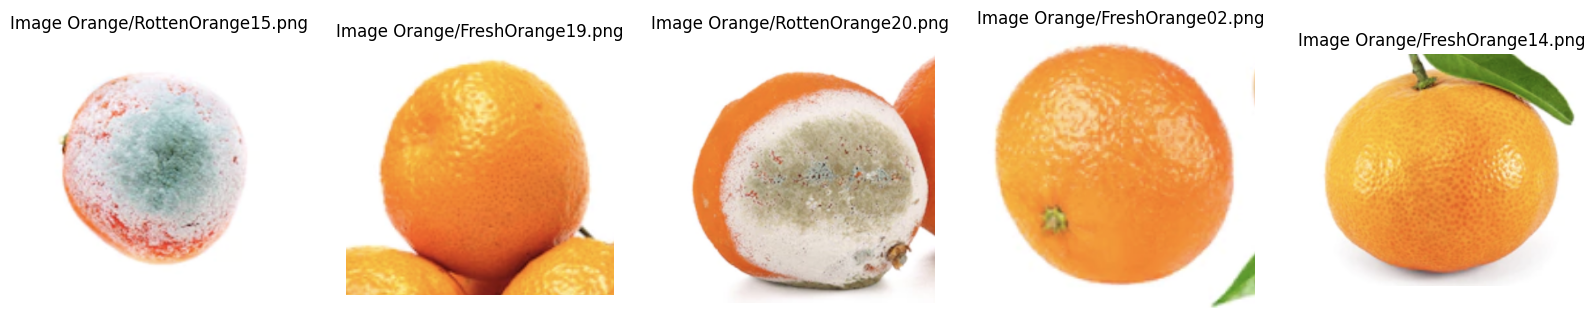

================================================================================ - Finish: ShowRandomImage


In [36]:
FileNameList, ImageList = ShowRandomImage(DatasetFiles, seedNo = 30)

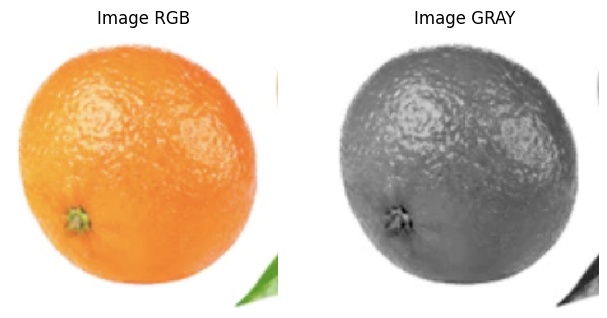

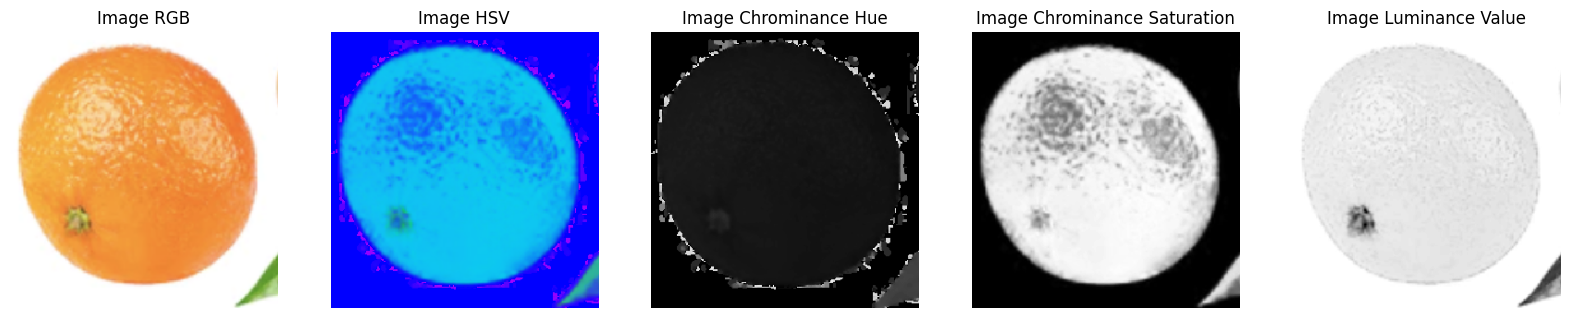

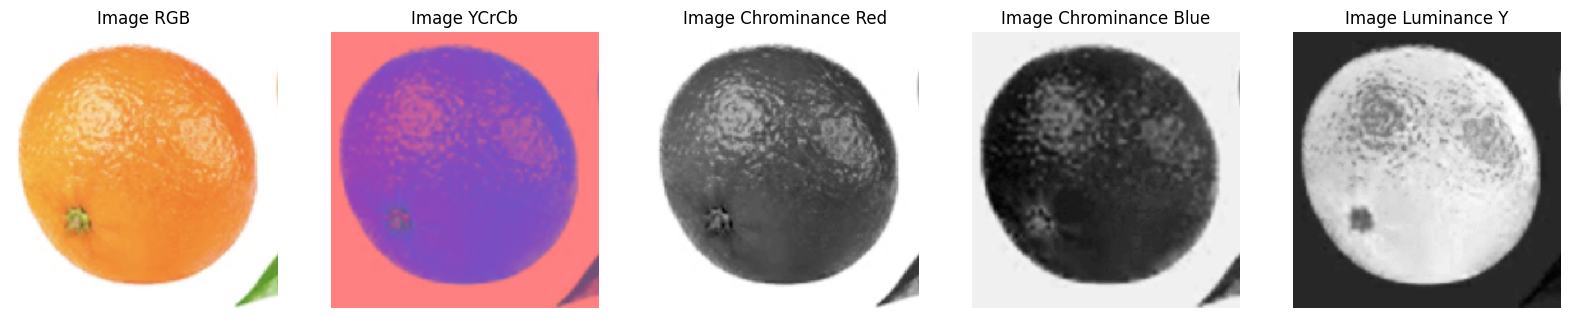

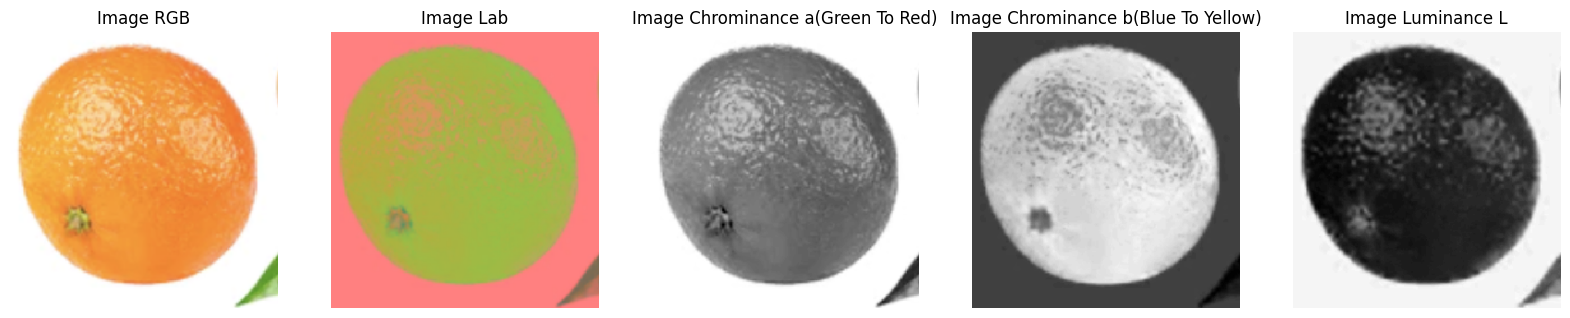

In [50]:
AnImage = ResizeImage(ImageList[3], 0, 300)
AnImage = (AnImage*255).astype(np.uint8)
image_gray = ConvertColorSpaces(AnImage, ColorSpace = "GRAY")
image_hsv = ConvertColorSpaces(AnImage, ColorSpace = "HSV")
image_ycrcb = ConvertColorSpaces(AnImage, ColorSpace = "YCrCb")
image_lab = ConvertColorSpaces(AnImage, ColorSpace = "Lab")

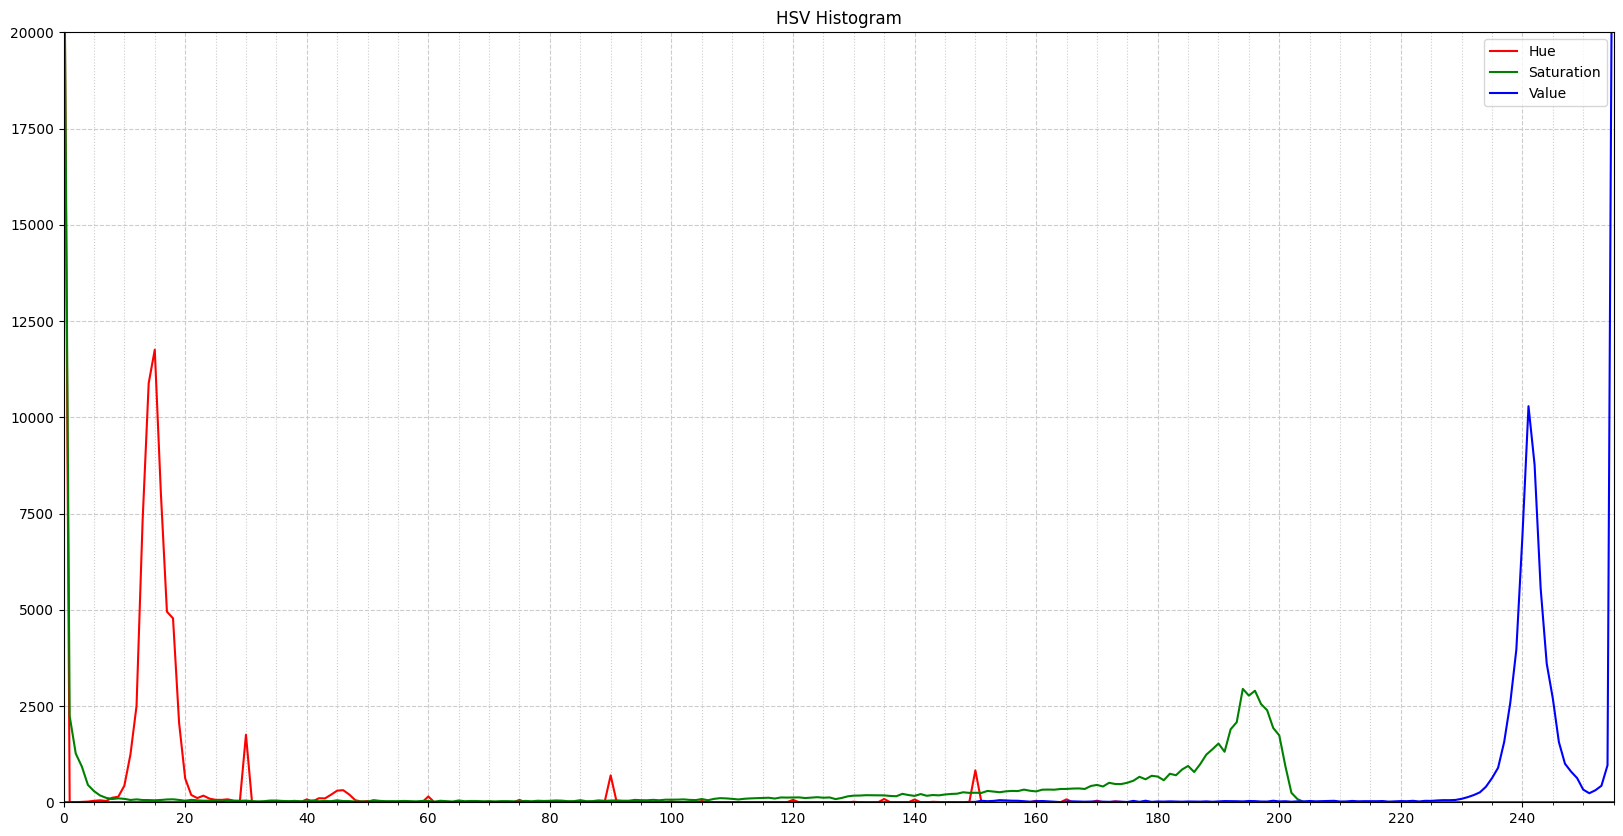

In [51]:
ShowHistogram(image_hsv, Title = "HSV Histogram", ChannelList = ["Hue", "Saturation", "Value"])

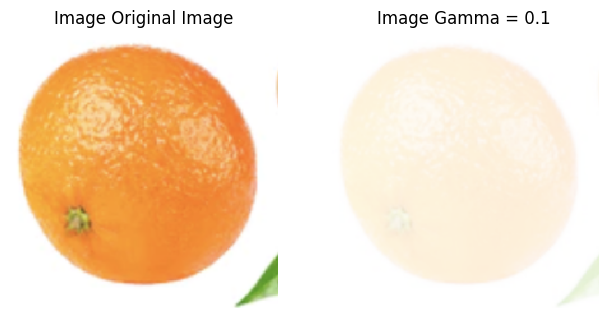

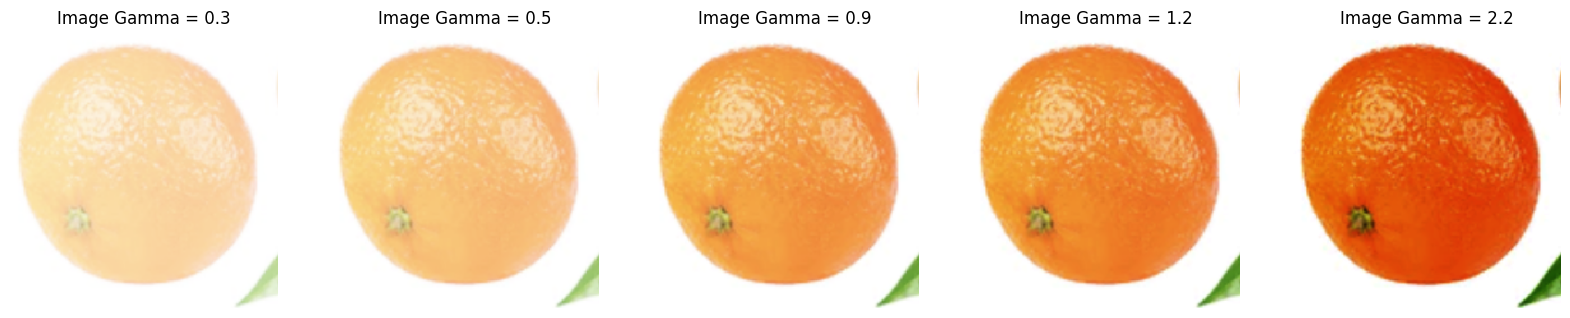

In [52]:
AnImage_Gamma = IntensityTransformation(AnImage, gamma = 0.1, display = 1)

In [53]:
hue = image_hsv[:,:,0]
saturation = image_hsv[:,:,1]
value = image_hsv[:,:,2]

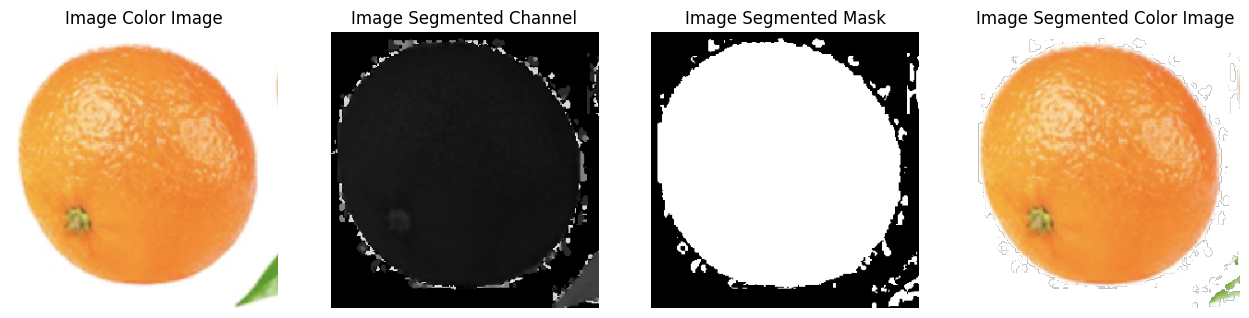

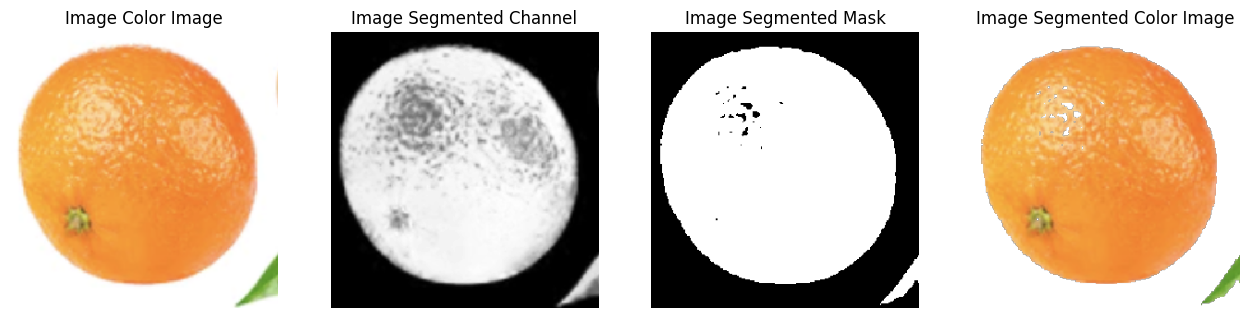

In [54]:
image_mask_bythresh1 = SegmentByThresh(AnImage, hue, segment_range = [0, 45])
image_mask_bythresh2 = SegmentByThresh(AnImage, saturation, segment_range = [100, 205])

Otsu Threshold : 68.0


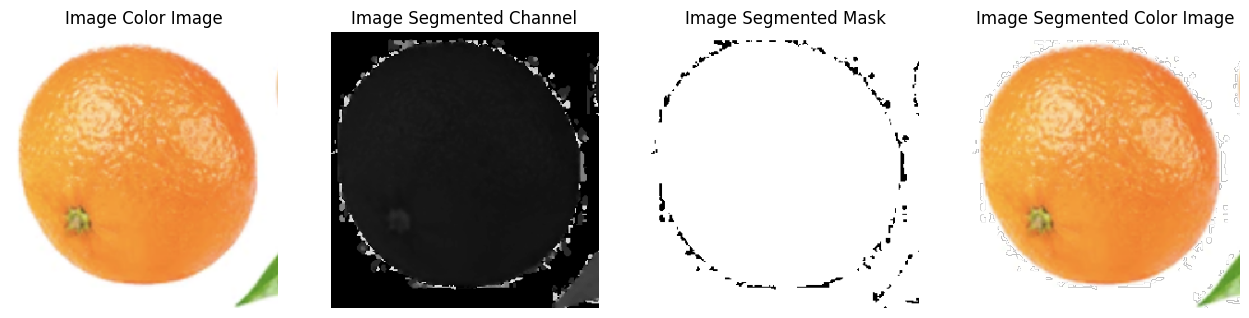

Otsu Threshold : 91.0


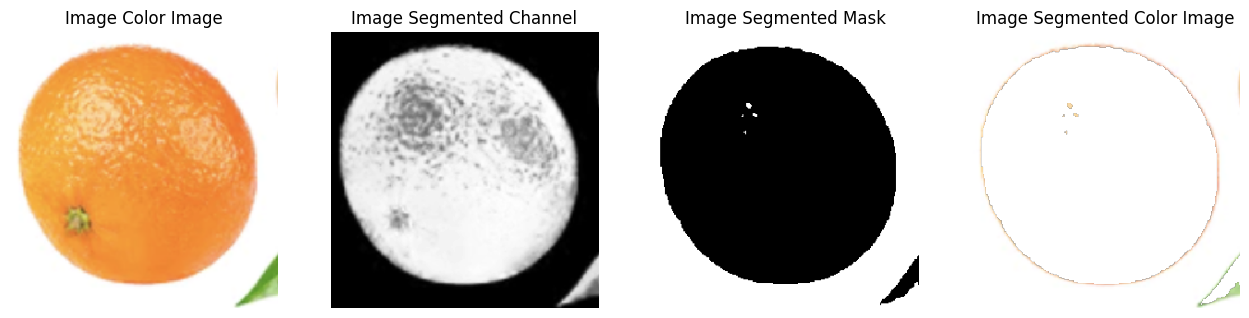

In [55]:
image_mask_byauto1 = SegmentByThresh(AnImage, image_hsv[:,:,0].astype(np.uint8))
image_mask_byauto2 = SegmentByThresh(AnImage, image_hsv[:,:,1].astype(np.uint8))

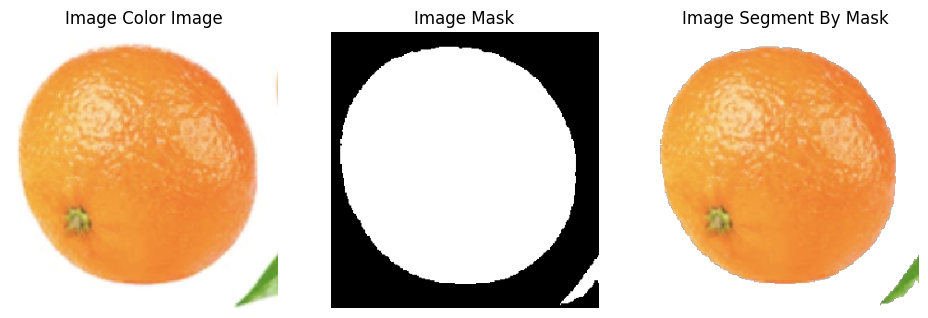

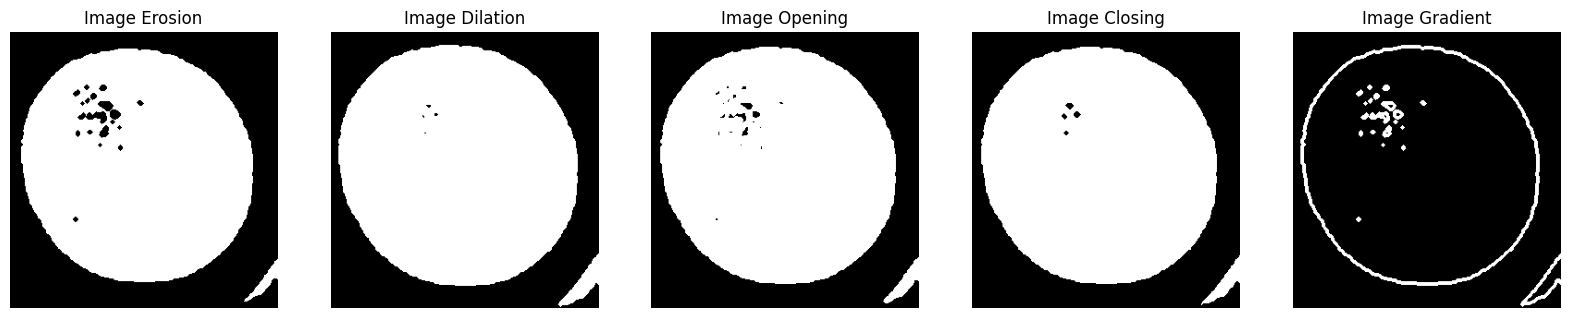

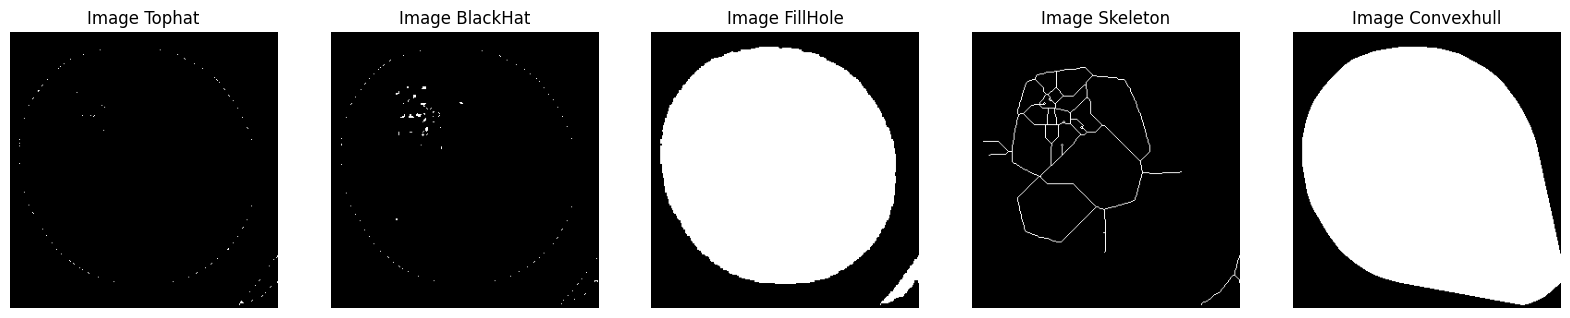

In [61]:
mage_mask_bythresh = image_mask_bythresh2.copy()
image_mask_adjust = Morphology(AnImage, image_mask_bythresh2, morType = "fillhole", size = 2, display = 1)

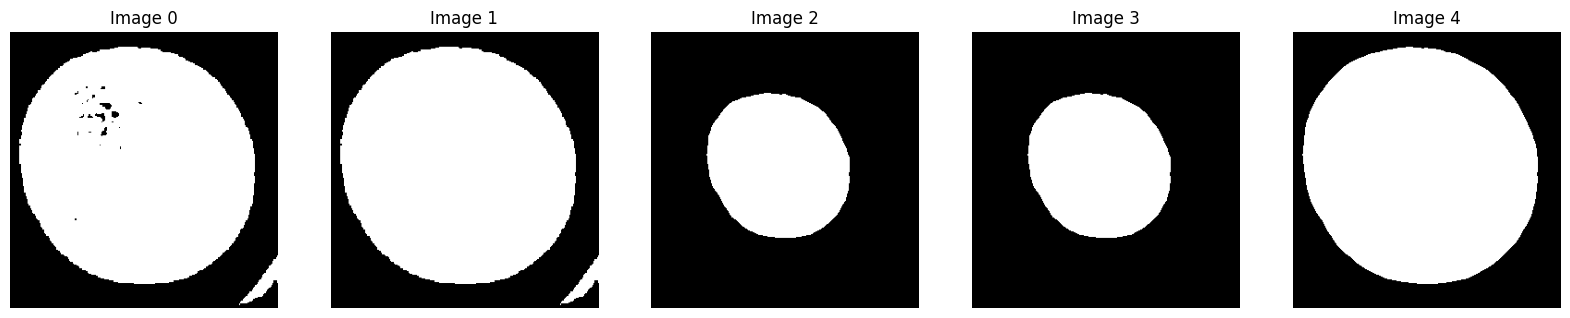

In [57]:
image_mask_adjust = doOrangeMaskSegment2(AnImage, image_mask_bythresh2, display = 1)

# 1. Mass Segmentation

In [67]:
!mkdir "Orange (Output)"

In [110]:
def FilterName(DatasetFiles, name):
    filtered_files = []
    for file_name in DatasetFiles:
        if name in file_name:
            filtered_files.append(file_name)
    return filtered_files

In [114]:
def GetImageList(DatasetFiles):
    ImageList = []
    for filepath in DatasetFiles:
        image_BGR = cv2.imread(filepath)
        image_RGB = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB)
        ImageList.append(image_RGB)
    return ImageList

In [116]:
fresh_paths = FilterName(DatasetFiles, "Fresh")
rotten_paths = FilterName(DatasetFiles, "Rotten")
ImageFreshList = GetImageList(fresh_paths)
ImageRottenList = GetImageList(rotten_paths)

In [118]:
def segment_orange(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower_orange = np.array([11, 100, 100])
    upper_orange = np.array([25, 255, 255])
    mask = cv2.inRange(hsv_image, lower_orange, upper_orange)
    segmented_image = cv2.bitwise_and(image, image, mask=mask)
    gray = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2GRAY)
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contoured_image = image.copy()
    cv2.drawContours(contoured_image, contours, -1, (0, 255, 0), 3)
    largest_contour = max(contours, key=cv2.contourArea)
    mask_largest = np.zeros_like(gray)
    cv2.drawContours(
        mask_largest, [largest_contour], -1, color=255, thickness=cv2.FILLED
    )
    segmented_orange = cv2.bitwise_and(image, image, mask=mask_largest)
    return segmented_orange, contoured_image

def segment_many_oranges(images):
    segmented_images = []
    for image in images:
        np_image = np.array(image)
        segmented_image, contoured_image = segment_orange(np_image)
        segmented_images.append(segmented_image)
    return segmented_images

In [ ]:
for filepath in DatasetFiles:
  print("=" * 80, f"Process Image : {filepath}")
  AnImage = imread(filepath)
  AnImage = ResizeImage(AnImage, 0, 300)
  AnImage = (AnImage*255).astype(np.uint8)
  AnImage = cv2.cvtColor(AnImage, cv2.COLOR_BGRA2BGR)


  image_hsv = ConvertColorSpaces(AnImage, ColorSpace = "HSV", display = 0)

  hue = image_hsv[:,:,0]
  saturation = image_hsv[:,:,1]
  value = image_hsv[:,:,2]
  image_mask_bythresh = SegmentByThresh(AnImage, saturation, segment_range = [100, 205], display = 0)
  image_mask_adjust = doOrangeMaskSegment2(AnImage, image_mask_bythresh, display = 0)
  result = GenerateOutput(AnImage, image_mask_adjust, FilePath = filepath, SaveFolderPath = "Orange (Output)")
  (image_output_rgbmask, image_output_fill, image_output_bbox, image_output_boundary, DemoImage) = result

  ShowImage([image_output_rgbmask, image_output_fill, image_output_bbox, image_output_boundary], 1, 5)

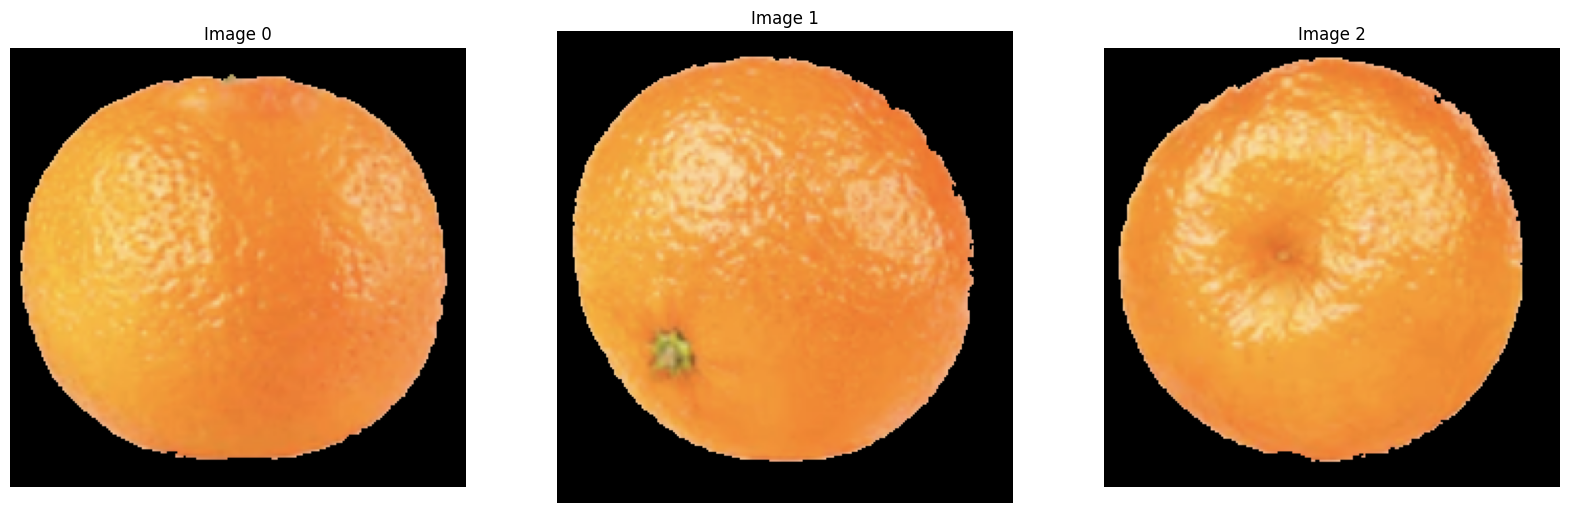

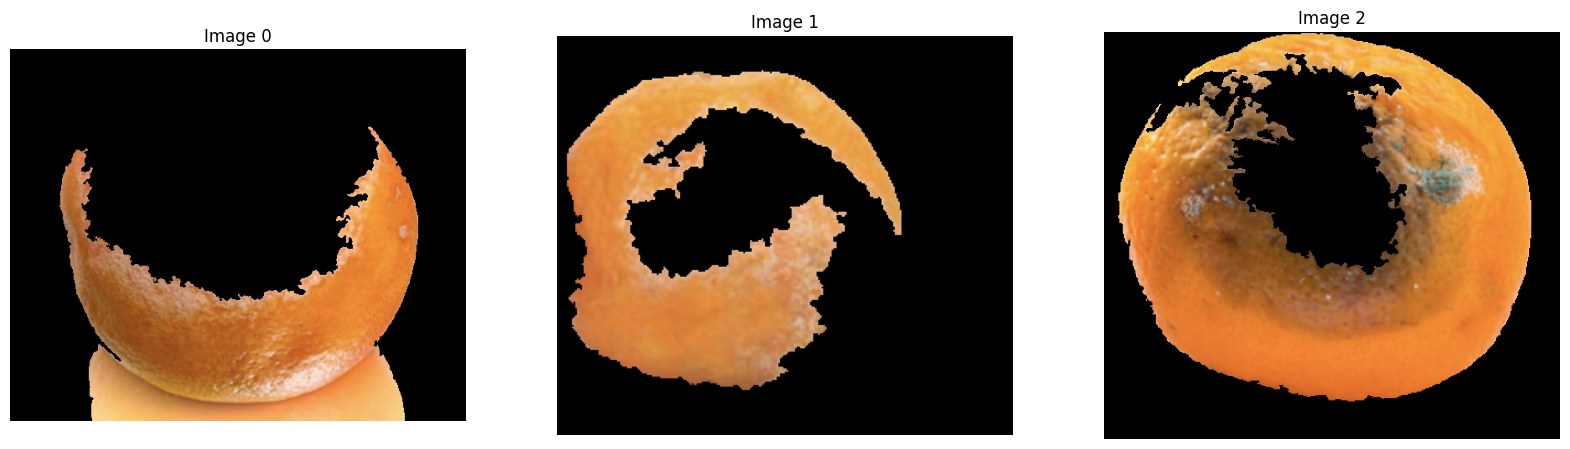

In [120]:
segmented_fresh_oranges = segment_many_oranges(ImageFreshList)
segmented_rotten_oranges = segment_many_oranges(ImageRottenList)
ShowImage(segmented_fresh_oranges[:3], 1, 3)
ShowImage(segmented_rotten_oranges[:3], 1, 3)

# 2. Thành lập 1 table có 2 lớp là fresh và rotten

In [106]:
def extract_features(segmented_img, contour):
    features = {}
    gray_img = cv2.cvtColor(segmented_img, cv2.COLOR_RGB2GRAY)
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    features["area"] = area
    features["perimeter"] = perimeter
    for i, color in enumerate(["red", "green", "blue"]):
        hist = cv2.calcHist([segmented_img], [i], None, [256], [0, 256])
        features[f"{color}_hist"] = hist.flatten()
    hsv_img = cv2.cvtColor(segmented_img, cv2.COLOR_RGB2HSV)
    for i, color in enumerate(["hue", "saturation", "value"]):
        hist = cv2.calcHist([hsv_img], [i], None, [256], [0, 256])
        features[f"{color}_hist"] = hist.flatten()
    moments = cv2.moments(contour)
    features["aspect_ratio"] = moments["nu20"] / moments["nu02"]
    features["rectangularity"] = area / (
        cv2.minAreaRect(contour)[1][0] * cv2.minAreaRect(contour)[1][1]
    )
    features["circularity"] = ((perimeter**2) / area) if area > 0 else 0
    return features

In [107]:
def extract_many_features(segmented_images):
    features_list = []
    for segmented_image in segmented_images:
        largest_contour = max(
            cv2.findContours(
                cv2.cvtColor(segmented_image, cv2.COLOR_RGB2GRAY),
                cv2.RETR_EXTERNAL,
                cv2.CHAIN_APPROX_SIMPLE,
            )[0],
            key=cv2.contourArea,
        )
        features = extract_features(segmented_image, largest_contour)
        features_list.append(features)
    return features_list

In [121]:
features_fresh_oranges = extract_many_features(segmented_fresh_oranges)
features_rotten_oranges = extract_many_features(segmented_rotten_oranges)

In [122]:
import pandas as pd

areas = []
perimeters = []
aspect_ratios = []
labels = []

for feature in features_fresh_oranges:
    areas.append(feature["area"])
    perimeters.append(feature["perimeter"])
    aspect_ratios.append(feature["aspect_ratio"])
    labels.append("Fresh")

for feature in features_rotten_oranges:
    areas.append(feature["area"])
    perimeters.append(feature["perimeter"])
    aspect_ratios.append(feature["aspect_ratio"])
    labels.append("Rotten")

feature_table = {
    "Class": labels,
    "Area": areas,
    "Perimeter": perimeters,
    "Aspect Ratio": aspect_ratios,
}

df_features = pd.DataFrame(feature_table)
df_features

Class      Area    Perimeter  Aspect Ratio
0    Fresh   29978.0   661.955406      1.212107
1    Fresh   33010.5   716.482317      0.969490
2    Fresh   28709.0   672.925967      1.025575
3    Fresh   66148.0  1222.655977      1.520539
4    Fresh   86373.5  1270.981877      1.341292
5    Fresh  107234.0  1330.680362      1.156883
6    Fresh   95896.5  1587.800199      1.125532
7    Fresh   70160.0  1287.224518      1.737084
8    Fresh   79090.5  1823.055031      1.486328
9    Fresh   75234.0  1942.802287      0.787331
10   Fresh  160094.0  2242.601276      1.461063
11   Fresh   93052.5  1415.976826      1.139152
12   Fresh   35464.0   767.352373      1.228878
13   Fresh   61982.5  1027.217378      1.425418
14   Fresh   49794.5  1123.727044      0.893060
15   Fresh   32883.5   695.511752      1.010343
16   Fresh   45017.0   823.151363      1.289307
17   Fresh   86889.0  1206.655975      1.158565
18   Fresh   25429.5   826.364566      1.474761
19   Fresh   65255.5  1219.182887      1.333703
20  Rotten   75586.5  2432.760657      2.600925
21  Rotten   18831.0  1409.935193      0.827498
22  Rotten   75690.5  3147.735391      1.485506
23  Rotten  124106.0  1680.621486      1.548400
24  Rotten   19351.5  1303.893564      0.208847
25  Rotten  143131.5  1986.687501      1.164697
26  Rotten   26655.0  1716.670254      1.086829
27  Rotten   15645.5  1517.893565      2.338292
28  Rotten    2504.5   297.237588     12.813176
29  Rotten   41508.0  2511.561734      1.890694
30  Rotten  113998.0  1289.910810      0.868763
31  Rotten  121488.5  1315.609294      1.085263
32  Rotten   21319.5  2216.584030      7.415880
33  Rotten   31379.5  3570.862370      0.913260
34  Rotten     214.5   136.468036     17.664125
35  Rotten   23976.5  1886.250990      0.176528
36  Rotten    2179.5   376.835567     14.877406
37  Rotten    5078.5   804.021419      3.570364
38  Rotten    6313.0  1169.425528      0.791672
39  Rotten   11038.0   880.950352      0.595991

# 3. Áp dụng 1 thuật toán MLs để học và phân loại giữa trái cam fresh và rotten

In [123]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

X = df_features[["Area", "Perimeter", "Aspect Ratio"]].values
y = df_features["Class"].map({"Fresh": 1, "Rotten": 0}).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

clf = SVC(kernel="linear")
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {round(accuracy*100, 2)}%")
print(report)

Accuracy: 87.5%
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.80      1.00      0.89         4

    accuracy                           0.88         8
   macro avg       0.90      0.88      0.87         8
weighted avg       0.90      0.88      0.87         8

